# CAB420, Dimension Reduction, Example 5: Eigenfaces
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
The "Eigenfaces" method for face recognition is an enduring pattern recognition method, that has also been applied to most (all?) other biometrics. While it's been totally superceeded by more recent methods, it's still a great demonstration of dimension reduction.

## Too Long; Didn't Read
The main take home points from this example are:
* In real world datasets, often the vast majority of information is in a small number of principal components (compared to the overall number of dimensions), and dimensions can be reduced with little impact on performance
* Components that have less variance tend to capture fine details within the data, while major components capture the overall shape and structure
* We can learn classifiers (or other things) in the compressed space by removing unwanted components
* Learning in the compressed space may not improve performance (it depends on the task and the method used), but it will improve efficiency which for some applications is very important

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## Step 1: Preprocessing
We're going to use the YaleB face dataset, which has already been cropped, converted to greyscale, and shrunk to 32x32 images. There are some reasons for this:
* Cropped because PCA requires the data to be aligned, in the case of images, this means things like the eyes, nose, etc, being in the same place in each image.
* Greyscale, because it allows us to reduce the dimensionality without really losing a lot of data, and also helps deal with issues such as white balance. It also makes results a bit easier to visualise.
* Downsampled becuase we need more samples than we have dimensions. Thus, megapixel images, while nice, will mean that we need millions of images (and lots of CPU grunt to push the numbers around).

With that out the way, we'll load the data.

In [2]:
yale_b = scipy.io.loadmat('../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])
print(numpy.shape(fea))

(2414, 1024)


Before we go anywhere, it's worth having a look at the data and how it's aranged. At present, we don't have what we'd conventially call images.

Instead we have images that have been "vectorised". This just means that all the columns have been stacked one on top of the other, so rather than being 32x32 it's 1x1024.

We can reshape this if we want to get back to images using this:

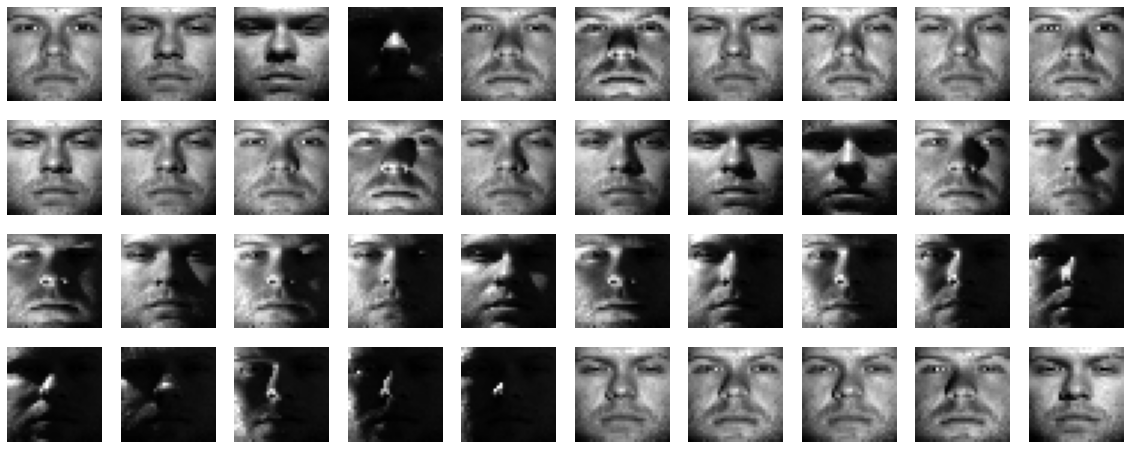

In [3]:
faceW = 32
faceH = 32
fea_reshape = numpy.reshape(fea.transpose(), (faceW, faceH, 1, len(fea)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(fea_reshape[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

That said, aside from for visualisation, we don't want to do this. PCA (and LDA) want a vector per sample - so vectorised images it is. 

It's worth thinking about how this differs from other models such as DCNNs. DCNNs take in images as images (we could provide them as vectors if we wanted to though) and that means that DCNNs gain some spatial awareness. As such, DCNNs can understand things like the eyes, ears, mouth and nose, and how they are located relative to each other and combined to form a face overall. While vectorising an image doesn't make this impossible, it does make it a lot harder.

Back to the images, they're faces. They're pretty well centred in the frames, and the lighting is a bit all over the shop.

Finally, let's get a train and test split going on. We have up to 64 images per face in the data. Let's pull out eight images per face for testing. The rest of the faces will stay in the training set.

In [4]:
numpy.random.seed(4)
test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]

print(numpy.shape(train_fea))
print(numpy.shape(test_fea))

(2196, 1024)
(228, 1024)


As per usual, we can check the size of our training and testing features as a sanity check.

## Step 2: PCA

We have some data, we'll compute our PCA space now and have a look at what we can do.

We'll start by getting our mean face and subtracting that from our face vectors. While we don't need to do this (the PCA function will do it for us), it's a good thing to visualise and there's no harm in doing this bit of pre-processing here.

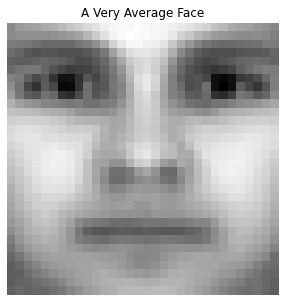

In [5]:
meanface = numpy.reshape(numpy.mean(train_fea, axis=0), (-1, 1));
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(1, 1, 1)
meanface_im = numpy.reshape(meanface, (32, 32))    
ax.imshow(meanface_im.transpose(), cmap=plt.get_cmap('gray'))
ax.set_axis_off()
ax.set_title('A Very Average Face');

Note that I've also applied this same subtraction operation to the test data, and that I use the mean on the training data here, rather than compute another mean.

Note also there is no standardisation. Why not? We have image data, which has to be in a fixed range of 0..255. All pixels are in the same range, so no one dimension has a bigger range than the others and there standardisation simply does not make sense.

Now we can compute PCA.

In [6]:
pca = decomposition.PCA()
pca.fit(train_fea)
transformed = pca.transform(train_fea)

One benefit of working with images is that we can visualise things, and in this case we can visualise our principal components. Here's the first 80.

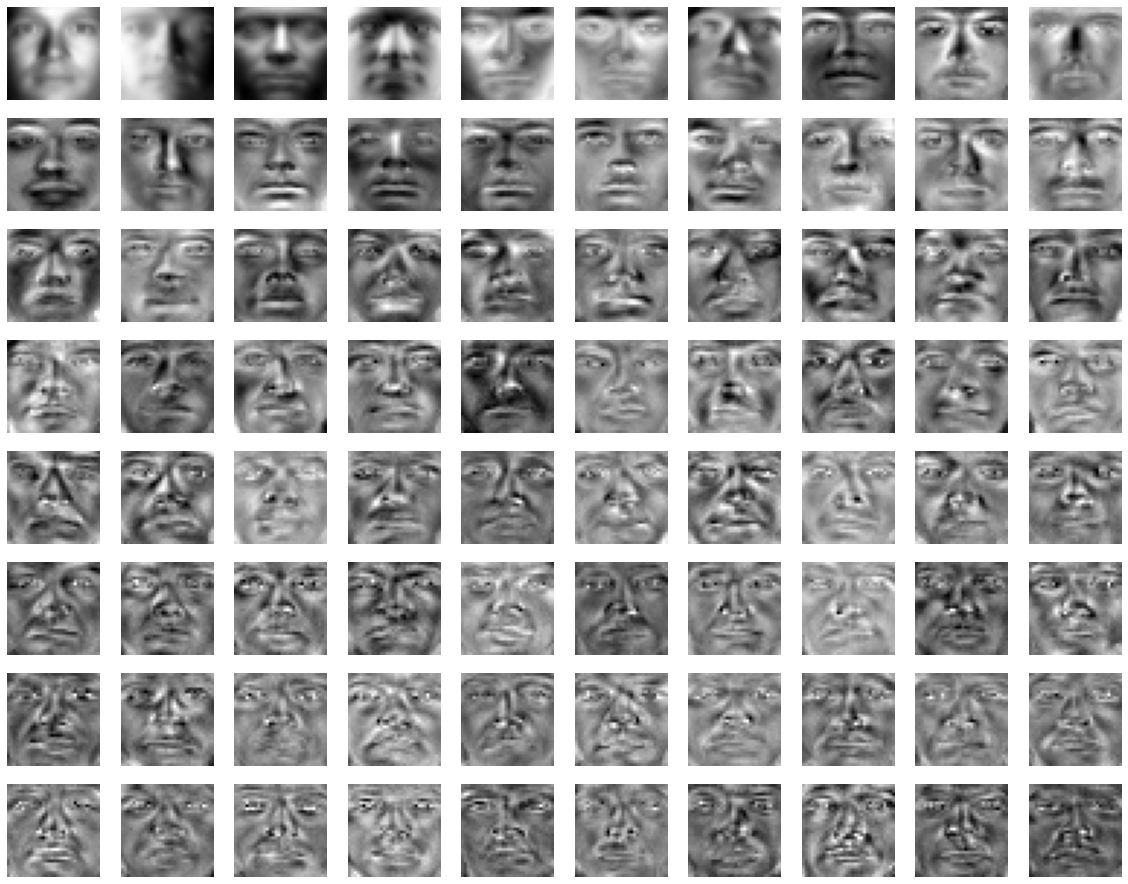

In [7]:
fig = plt.figure(figsize=[20, 16])
for i in range(80):
    ax = fig.add_subplot(8, 10, i + 1)
    pc = numpy.reshape(pca.components_[i,:], (32, 32))        
    ax.imshow(pc.transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

They look like faces, and these can be seen as the "main components" of the faces in our data. What we see is the first ~15 or so concern lighting. We see different shadow patterns being cast across the faces. These all pretty much look like faces.

As we get further into the components, things get a bit weirder. Here things all still look like faces, but they start to get a little warped and twisted. We can think of these components are capturing different face structures; i.e. eyes at different distances, different sized nose and mouth, etc. 

Let's look at how much of our data is explained by all our components.

Text(0.5, 0, 'Number of Components')

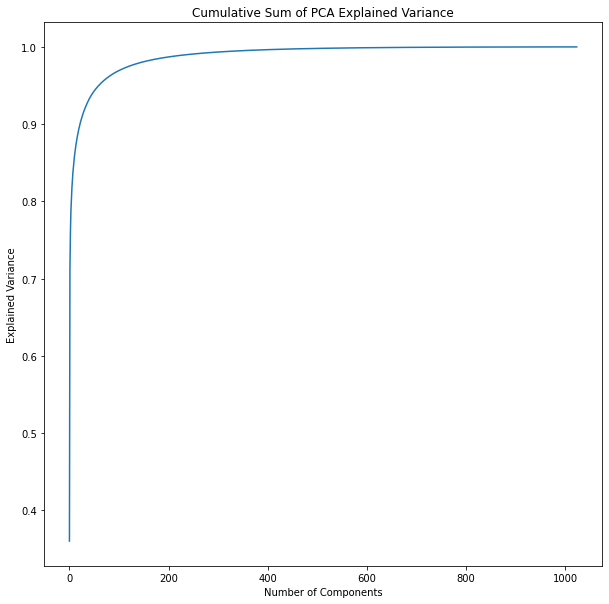

In [8]:
cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

In [9]:
top90 = numpy.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = numpy.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = numpy.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 23 components
95% in 61 components
99% in 238 components


23 components, a bit over 2% of the total dimensions, explain 90% of the variation. We can get to 95% with just 60, and 99% with 238 - so the last ~800 dimensions really aren't contributing much.

Given the visualisation above, this suggests that the vast amount of variation we are seeing in the dataset is coming from the changes in lighting. Intuitivley this makes sense.

Looking at some reconstructions below, we see some interesting results.

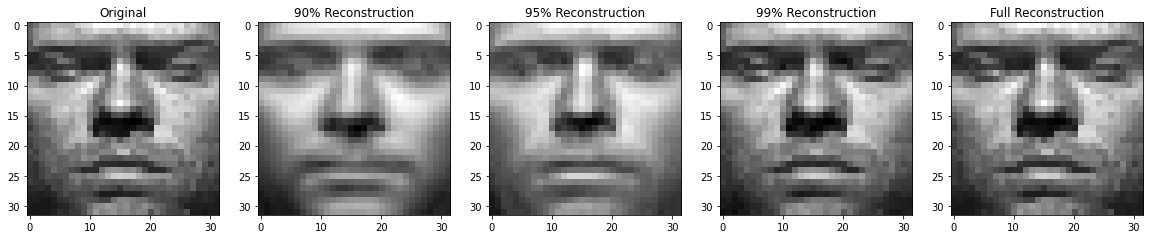

In [10]:
face_id = 1

fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 5, 1)
ax.imshow(numpy.reshape(train_fea[face_id,:] - pca.mean_, (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Original');

ax = fig.add_subplot(1, 5, 2)
ax.imshow(numpy.reshape(pca.components_[0:top90,:].transpose().dot(numpy.reshape(transformed[face_id,0:top90], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction');

ax = fig.add_subplot(1, 5, 3)
ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[face_id,0:top95], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction');

ax = fig.add_subplot(1, 5, 4)
ax.imshow(numpy.reshape(pca.components_[0:top99,:].transpose().dot(numpy.reshape(transformed[face_id,0:top99], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction');

ax = fig.add_subplot(1, 5, 5)
ax.imshow(numpy.reshape(pca.components_[:,:].transpose().dot(numpy.reshape(transformed[face_id,:], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction');

Using only the first 23 components (90% of the variance), we see that we lose a lot of the content that makes that person look like them. The 23 component verion looks very generic. As we add more components, we add a lot more of the information that makes the person unique. The final step, from 99% to the full reconstruction, we see that it's only very fine grained information that being added.

To an extent, we can view the dimension reduced versions as blurred versions - certainly for the 95%, 99% and full reconstructions what's being lost is high frequency details.

### Operating in the Dimension Reduced Space

Now we can operate in a reduced space. Let's go with the first 23 components for our test set.

Let's grab a new face and transform that into our new coordinate space, then we'll try to find a match for it in the training set.

In [11]:
# transform the training data
transformed_train_90 = transformed[:, 0:top90]

# transform the test set
transformed_test = pca.transform(test_fea)
transformed_test_90 = transformed_test[:, 0:top90]

# for the first test face, find the closest face in the training set
distance = numpy.sqrt(numpy.sum((transformed_train_90 - transformed_test_90[0,:])**2, axis=1))

# get the index of the closest face
index_min = numpy.argmin(distance)

# and get the ID of the two faces - ideally these should match 
print(train_gnd[index_min])
print(test_gnd[0])

[15]
[1]


In this case, we see that our face is not a match, but keep in mind that we've pulled out just the first match.

## Face Recognition
At this point, you can hopefully see how face rec will work with Eigenfaces. We will keep this simple and use a CKNN classifier (this was actually a pretty common approach too). For interest, we'll train four:
* One using the top 90% of the variance
* One using the top 95% of the variance
* One using the top 99% of the variance
* One using the raw pixels 

For all of these, I'm going to use 10 neighbours, and inverse weighted distance. There is no grand reason for this, and no attempt to find the best parameters has been made - this is just what I've chosen to use.

In [12]:
transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]
transformed_train_99 = transformed[:, 0:top99]
transformed_test_99 = transformed_test[:, 0:top99]

train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 12])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))

### Top 90%

Test Accuracy: 0.40350877192982454


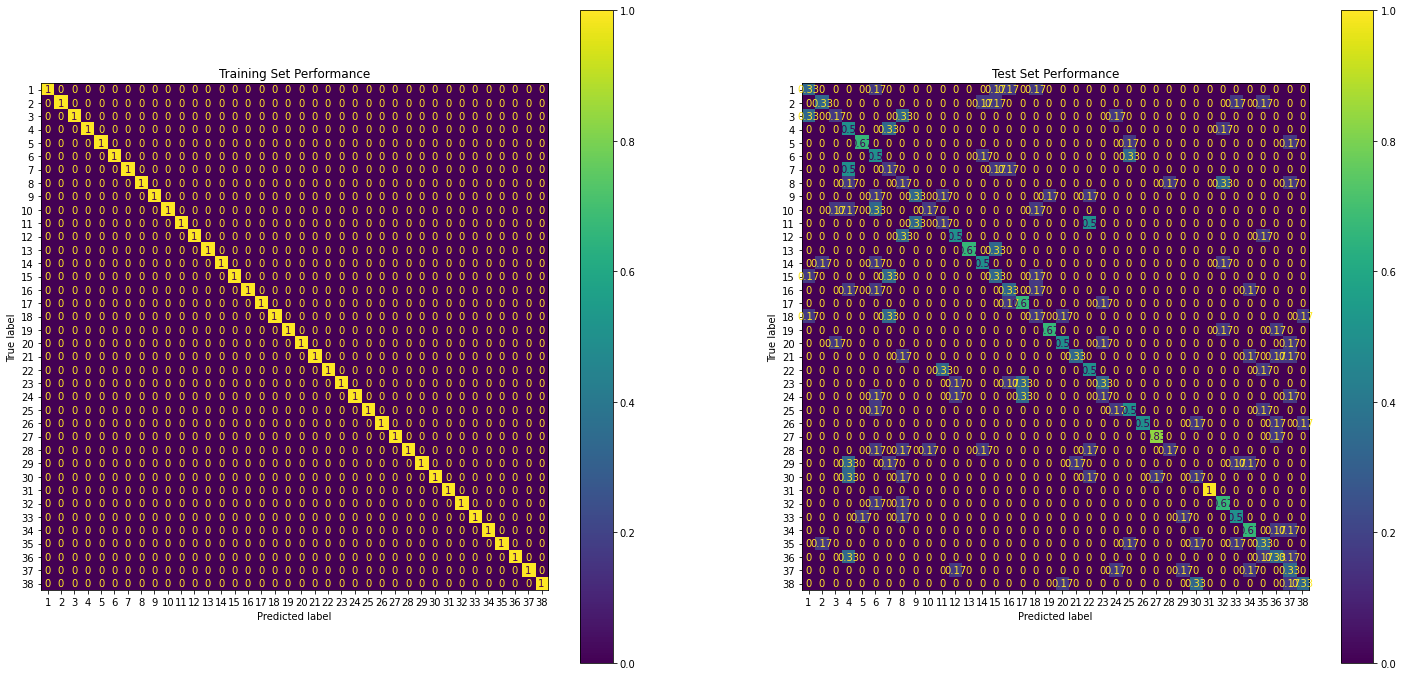

In [13]:
cknn_90 = KNeighborsClassifier(n_neighbors=1, weights='distance')
cknn_90.fit(transformed_train_90, train_gnd)
eval_model(cknn_90, transformed_train_90, train_gnd, transformed_test_90, test_gnd)

### Top 95%

Test Accuracy: 0.5701754385964912


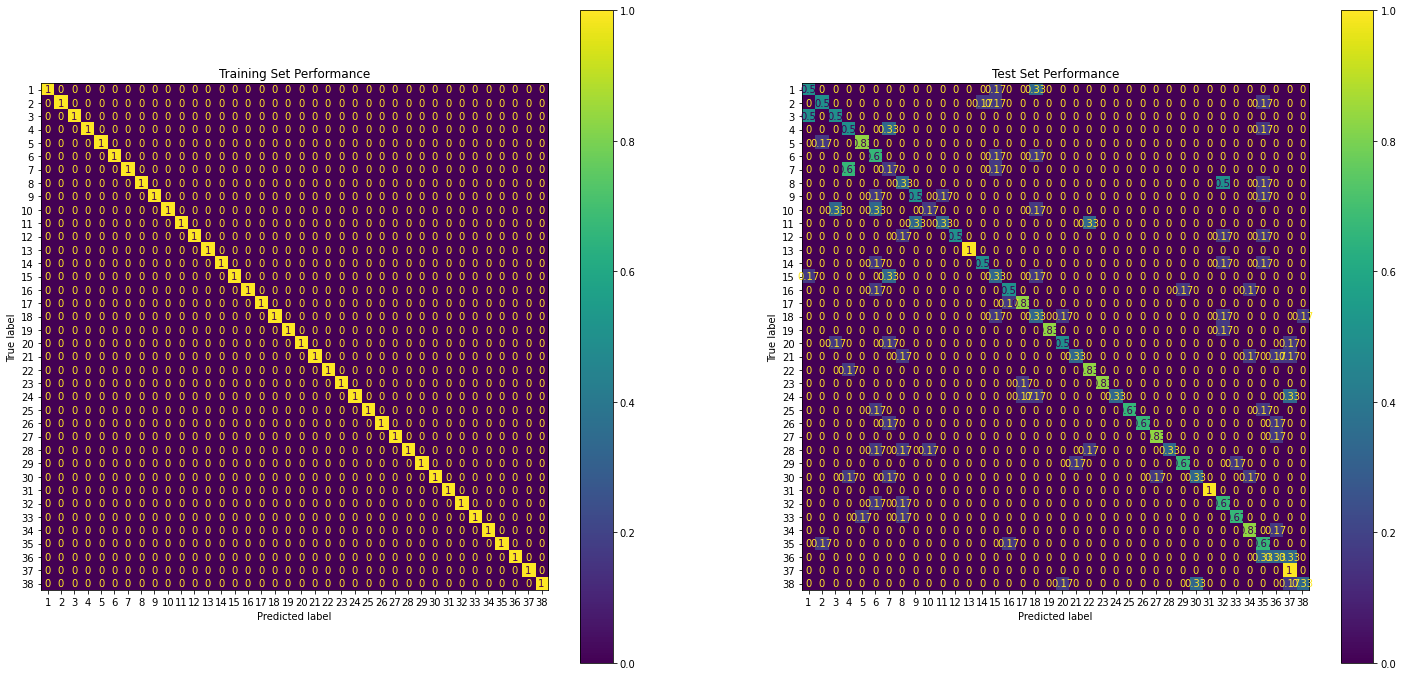

In [14]:
cknn_95 = KNeighborsClassifier(n_neighbors=1, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)

### Top 99%

Test Accuracy: 0.7149122807017544


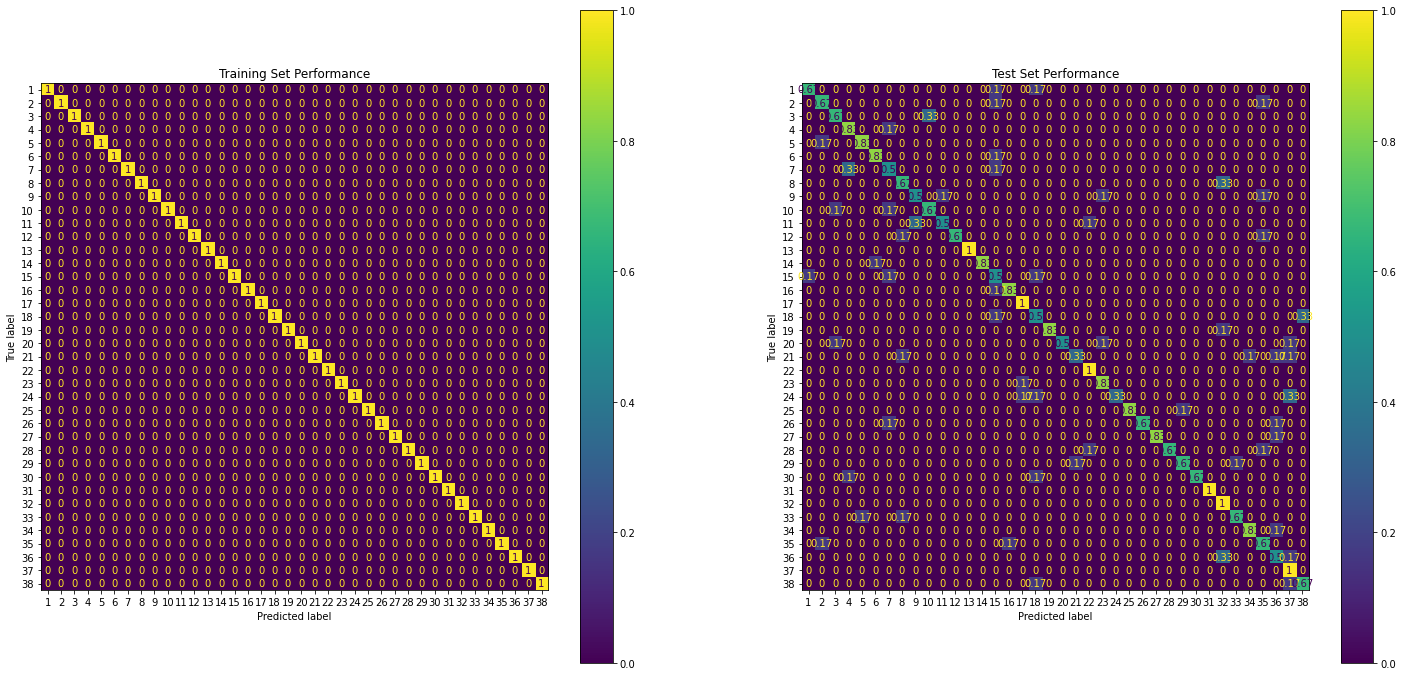

In [15]:
cknn_99 = KNeighborsClassifier(n_neighbors=1, weights='distance')
cknn_99.fit(transformed_train_99, train_gnd)
eval_model(cknn_99, transformed_train_99, train_gnd, transformed_test_99, test_gnd)

### Pixels

Test Accuracy: 0.7368421052631579


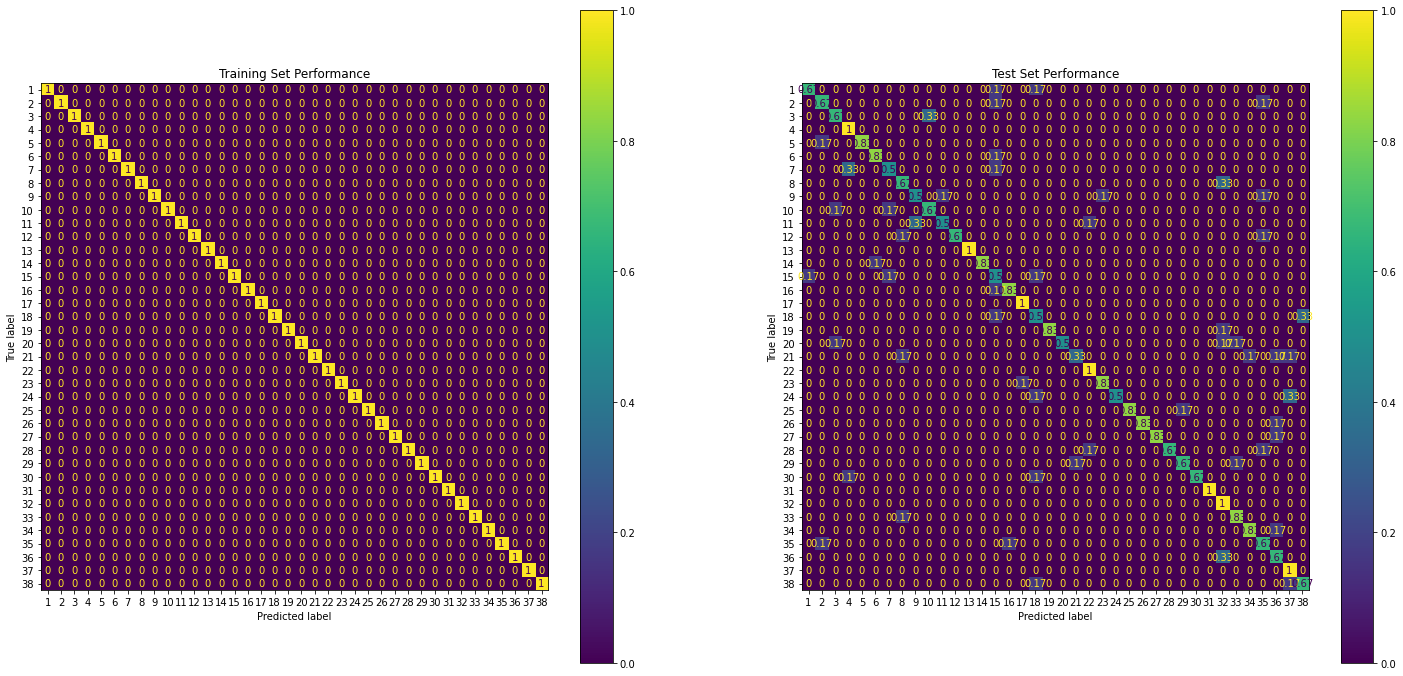

In [16]:
cknn_pix = KNeighborsClassifier(n_neighbors=1, weights='distance')
cknn_pix.fit(train_fea, train_gnd)
eval_model(cknn_pix, train_fea, train_gnd, test_fea, test_gnd)

We see that our 99% model is better than the 95% model, and this is better than the 90% one. Also, the pixel data model is surprisingly good (I thought it would be much worse). This may be helped by our large amount of training data (we have ~50+ images per person in our training data, this is a lot and helps greatly). That said, our pixel model is really not much better than our 99% model, and it's much slower.

## Why isn't PCA better?

Well, PCA doesn't actually change the data - it just rearranges it such that the most useful bits are at the front - but it does nothing to make classes easier to separate (that's LDA). We can potentially get a bit of that through taking only the top N dimensions and removing a bunch that are mostly noise, but not always. To explore this a bit more, let's have a look at a different technique: t-Distributed Stochastic Neighbor Embedding, or t-SNE for short. 

In brief:
* t-SNE is another dimension reduction method, though this time for visualisation (usually, not always)
* t-SNE will project into two dimensions (usually), and aims to preserve the overall "shape" of the data
* This is done by learning a distribution of the data in the original high dimensional space, and then trying to mimic that in the low (2) dimensional space
* This means that both local and global relationships are (somewhat) preserved, though t-SNE does have lots of hyper-parameters (which we not looking into) which can alter performance
* t-SNE is non-deterministic, i.e. if you run it twice (with a different random seed each time) you'll get a different result.

t-SNE is quite a recent development (about 2008) and unlike PCA and LDA, t-SNE really exists for visualisation and visualisation only (though it does get used for other stuff - just make sure you know what you're doing if this is the case). 

So, let's apply t-SNE to some of our data. We'll run it on the training data, and use gscatter to plot the data and markup identies. What we'd idealy like to see is little tighly clustered blobs per identity.

Note that as t-SNE is non-deterministic, we'll reset the random seed each time we use it, and to be as correct as possible, we'll always set the random seed to 4.

In [17]:
embeddings_90 = TSNE(random_state=4).fit_transform(transformed_train_90)
embeddings_95 = TSNE(random_state=4).fit_transform(transformed_train_95)
embeddings_all = TSNE(random_state=4).fit_transform(transformed)
embeddings_pix = TSNE(random_state=4).fit_transform(train_fea)

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/

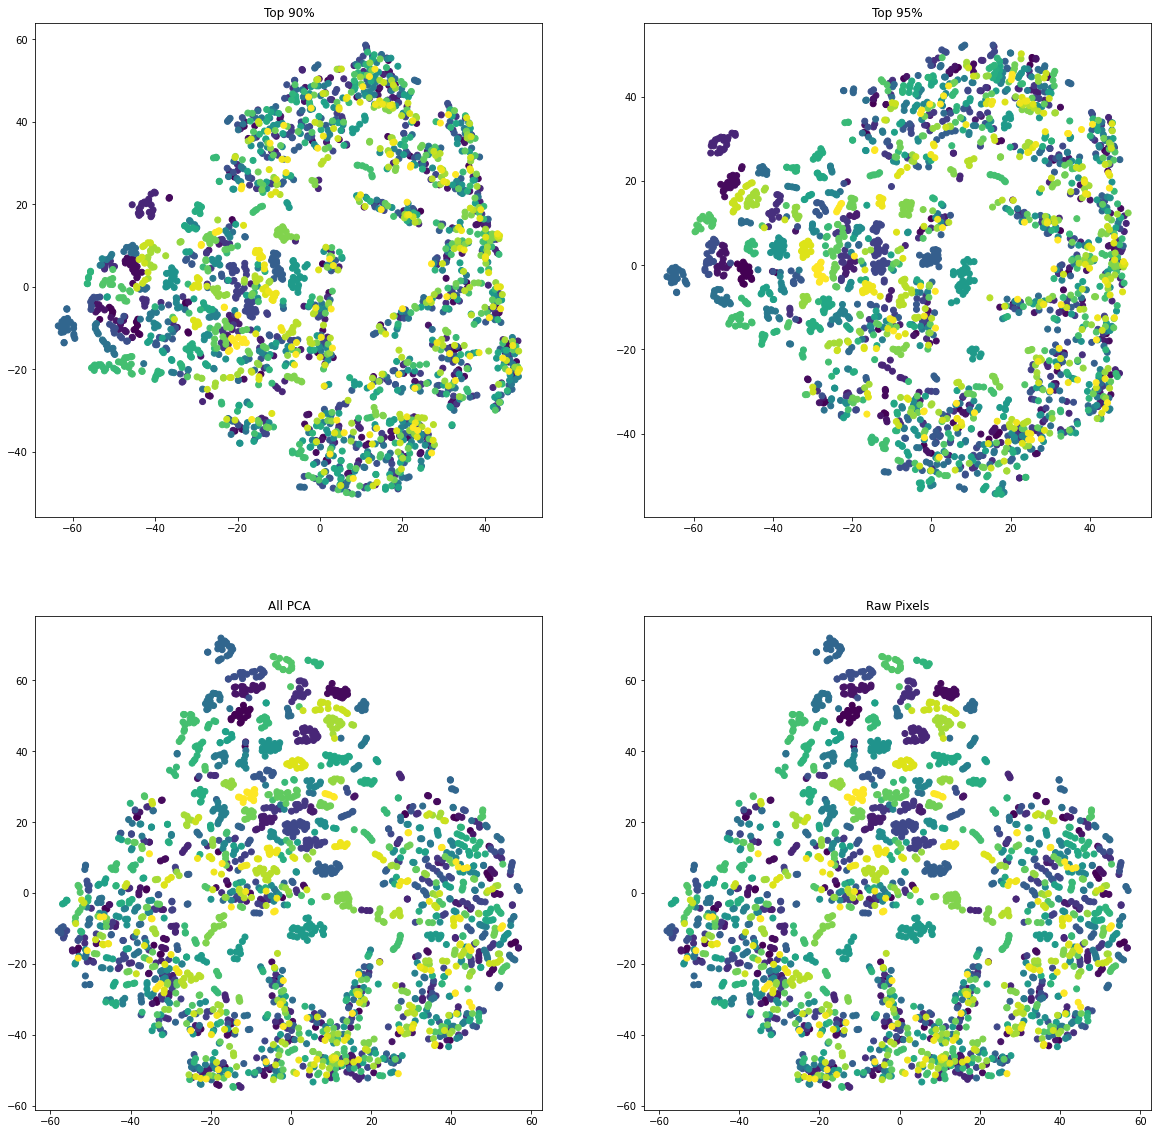

In [18]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(embeddings_90[:,0], embeddings_90[:,1], c=train_gnd)
ax.set_title('Top 90%')

ax = fig.add_subplot(2, 2, 2)
ax.scatter(embeddings_95[:,0], embeddings_95[:,1], c=train_gnd)
ax.set_title('Top 95%')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(embeddings_all[:,0], embeddings_all[:,1], c=train_gnd)
ax.set_title('All PCA')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(embeddings_pix[:,0], embeddings_pix[:,1], c=train_gnd)
ax.set_title('Raw Pixels');

What we see is that:
* For all four there is some clustering going on, there are also some faces that don't get clustered nicely. This makes sense given our accuracy, we really wouldn't expect it to look perfect
* The raw pixels and the full transfored data look close to identical. I can't see any difference, though there may be  a couple of slight differences somewhere, but the results are for all practical purposes the same. This backs up the face that PCA hasn't changed the data. The underlying distrubution (which is what t-SNE looks at) hasn't changed, so the results of t-SNE don't really change either
* We do see some bigger changes for the 90% and 95% version. Here's we've dropped a lot of the data, so while we've kept the most important bits (for reconstruction), we've dropped a lot of the other terms which does impact the distribution of the data, and this is reflected in the plot that we see. If we used more PCA coefficients, we'd get closer and closer to what we see in the "Pixels" version.

So, the take home message is perhaps that PCA won't suddenly make your data better, it can get rid of a lot of the useless stuff and help focus on the most informative parts. This means that, as we saw above, you can get equivilent performance with a fraction of the memory and compute cost. Sometimes that will also translate into an improvement for some tasks, but not always. As usual, it depends on the data.